In [17]:
using Serialization, Statistics, Distributions, StableRNGs, CSV, ForwardDiff, GlobalSensitivity
include("misc.jl")
include("ode_problem.jl")
include("target_probability.jl")
include("marginal_kl_divergence.jl")
include("sensitivity_analysis.jl");

RNG

In [18]:
rng = StableRNG(34627); #for sampling prior

Input Run Details

In [ ]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "200"
baseline_run = "201"
prior_nonbinding_offset = [2,2]
prior_binding_offset = [0,0]
prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset);

In [20]:
augmented_run = "204"
baseline_run = "205"
bound_offset = [1,1]
binding_bound_offset = [-1,-1]
prior_bounds = return_prior_bounds_empirical(bound_offset, binding_bound_offset) #for target probability
prior_bounds[1] = return_prior_bounds_empirical(bound_offset, [0,-2])[1] #shrink kon by 2 orders of magnitude, keeping ground truth in range

2-element Vector{Float64}:
 -4.714239202420308
 -2.714239202420308

In [21]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "202"
baseline_run = "203"
prior_nonbinding_offset = [3,3]
prior_binding_offset = [1,1]
prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset);

Calculate Quantiles of Posteriors

In [22]:
#load posterior samples - change name as necessary 
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#define priors
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate quantiles
lower_bound = 0.05
upper_bound = 0.95
my_quantiles = [[Statistics.quantile(baseline_samples[i,:], lower_bound), Statistics.quantile(baseline_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_aug = [[Statistics.quantile(aug_samples[i,:], lower_bound), Statistics.quantile(aug_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_priors = []
for i in 1:n_parameters
    bounds = prior_bounds[i]
    difference = bounds[2] - bounds[1]
    quantiles_offset = difference*lower_bound
    push!(my_quantiles_priors, [bounds[1]+quantiles_offset, bounds[2]-quantiles_offset])
end

#save 
serialize("outputs/600_$(baseline_run)_posterior_quantiles.jls", my_quantiles)
serialize("outputs/600_$(augmented_run)_posterior_quantiles.jls", my_quantiles_aug)
serialize("outputs/600_$(augmented_run)_prior_quantiles.jls", my_quantiles_priors)

Mean Absolute Error w.r.t. Posterior Samples

In [23]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate absolute error of each sample
abs_error = Base.stack([abs.(baseline_samples[:,i] .- ground_truth) for i in 1:n_samples])
abs_error_reg = Base.stack([abs.(aug_samples[:,i] .- ground_truth) for i in 1:n_samples])

#take mean of absolute errors for each parameter
mae = [sum(abs_error[i,:])/n_samples for i in 1:n_parameters]
mae_reg = [sum(abs_error_reg[i,:])/n_samples for i in 1:n_parameters]

#convert to dictionary
mae_dict = Dict(parameter_names[i] => mae[i] for i in 1:n_parameters)
mae_aug_dict = Dict(parameter_names[i] => mae_reg[i] for i in 1:n_parameters)

#save 
serialize("outputs/600_$(baseline_run)_mean_absolute_error.jls", mae_dict)
serialize("outputs/600_$(augmented_run)_mean_absolute_error.jls", mae_aug_dict)

Calculate KL Divergence for From Augmented to Baseline Posterior

In [24]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)
prior_distributions = [Uniform(prior_bounds[i]...) for i in 1:n_parameters]
prior_samples = transpose(Base.stack([rand(rng, prior_distributions[i], n_samples) for i in 1:n_parameters])) #ndims x nsamples 

#parameter names
parameter_names = return_inferred_parameters()
kl_div_augmented_baseline, parameter_names = kl_divergence_bits_samples(aug_samples, baseline_samples, parameter_names)
kl_div_baseline_prior, parameter_names = kl_divergence_bits_samples(baseline_samples, prior_samples, parameter_names)

#save
serialize("outputs/600_$(augmented_run)_$(baseline_run)_kl_div.jls", kl_div_augmented_baseline)
serialize("outputs/600_$(baseline_run)_prior_kl_div.jls", kl_div_augmented_baseline)

Calculate quantiles of finegrain predictions for which we have experimental data

In [25]:
data_files = readdir("data")
sort_files = data_files .!= ".DS_Store"
data_files = sort(data_files[sort_files]) #sort to ensure consistent order
sort_files = data_files .!= "predicted_kd.csv"
data_files = sort(data_files[sort_files])
quantity_names = [replace(data_files[i], ".csv" => "") for i in 1:length(data_files)];

In [26]:
for r in [augmented_run, baseline_run]    
    for i in quantity_names
        predictions = Base.stack(deserialize("outputs/500_$(r)_finegrain_predictions_$(i).jls")) #ntime x n
        n_time_points, n_predictions = size(predictions)
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        serialize("outputs/600_$(r)_prediction_quantiles_$(i).jls", Dict("lower_quantile"=>quantile_low, 
        "median"=>median, "upper_quantile" =>quantile_up))
    end
end

Calculate Quantiles of Predictions for All Species

In [28]:
#calculate quantiles
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles.jls", quantiles)
end

LoadError: EOFError: read end of file

In [ ]:
#calculate quantiles for finegrain predictions
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions_finegrain.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles_finegrain.jls", quantiles)
end 

LoadError: EOFError: read end of file

Local Sensitivity Analysis

In [ ]:
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]

#calculate local sensitivity of each species about this parameter value 
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1)
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
#redefined save at to be finer grain
#solver_inputs["saveat"] = return_finegrain_saveat()
local_sensitivity_kb = []
local_sensitivity_kf = []
local_sensitivity_nonbinding = []
for i in 1:n_doses
    odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[i])
    odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
    for j in 1:n_species
        local_sensitivity = ForwardDiff.jacobian(p -> local_sensitivity_analysis(p, odeprob, solver_inputs, j), max_likelihood_parameters)
        local_sensitivity_kb = cat(local_sensitivity_kb, [local_sensitivity[:,return_koff_indices()]], dims=1)
        local_sensitivity_kf = cat(local_sensitivity_kf, [local_sensitivity[:, return_kon_indices()]], dims=1)
        local_sensitivity_nonbinding = cat(local_sensitivity_nonbinding, [local_sensitivity[:, return_nonbinding_indices()]], dims=1)
    end
end
serialize("outputs/600_$(baseline_run)_local_sensitivity_kb.jls", local_sensitivity_kb)
serialize("outputs/600_$(baseline_run)_local_sensitivity_kf.jls", local_sensitivity_kf)
serialize("outputs/600_$(baseline_run)_local_sensitivity_nonbind.jls", local_sensitivity_nonbinding)

Reshape and save for correlation calculation between change in median and local sensitivity of parameters

In [ ]:
#calculate absolute difference between medians for each output of interest
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")
n_outputs = length(augmented_quantiles) #n_species x n_doses
n_timepoints = length(augmented_quantiles[1]["median"])
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end
#save
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)
serialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls", med_dif)

#load local sensitivity to parameter for each output of interest, reshape to match median difference, save
for i in ["kb", "kf", "nonbind"]
    local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_local_sensitivity_$(i).jls") #vector of n_outputs, each output is sensitivity matrix of n_timepoints x n_parameters
    #maximum across kb
    max_ls_kb = []
    for i in 1:n_outputs
        max_ls_kb = cat(max_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1) #take parameter with highest sensitivity for particular output
    end
    ls_kb = reshape(Base.stack(max_ls_kb), n_outputs*n_timepoints)
    serialize("outputs/600_$(baseline_run)_local_sensitivity_$(i)_1d.jls", ls_kb)
end

LoadError: SystemError: opening file "outputs/600_202_prediction_quantiles.jls": No such file or directory

Global Sensitivity Analysis

In [ ]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 5
#sensitivity analysis parameters
#get bounds based on max likelihood parameters
lb = max_likelihood_parameters.-2
ub = max_likelihood_parameters.+2
bounds = [[lb[i],ub[i]] for i in 1:n_parameters]
Ns = 10000 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 8 (number of parameters) 
#ode problem definition
#calculate local sensitivity of each species about this parameter value 
normalize_to = normalize_to_dose()
ligand_doses = cat(return_ligand_dose_nM(),normalize_to, dims=1) #normalize to last stimulation
n_doses = length(ligand_doses)
n_species = 5
solver_inputs = return_ode_problem_solver_default_inputs("timecourse")
solver_inputs["saveat"] = [0, 10, 30, 60, 120, 210, 300, 450, 600] #exclude timepoint 0, which is set

odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[end])
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, odeprob, solver_inputs, n_species), eFAST(), bounds, samples=Ns)

GlobalSensitivity.eFASTResult{Matrix{Float64}}([NaN NaN … NaN NaN; 0.952257064414132 1.1912050097004336e-5 … 1.8662018739522492e-5 1.9492053347577938e-5; … ; 3.237924065504669e-6 1.5450578287857687e-8 … 0.19437100569325833 0.36289978103945514; 4.205409941906061e-6 2.2098326055961463e-8 … 0.2021980582249355 0.3480790284473934], [NaN NaN … NaN NaN; 0.9829822310451259 0.0010100402938776343 … 0.002107593568066002 0.002090561691366899; … ; 0.007465348824223228 0.006168300648416558 … 0.3339004260173949 0.5235655057736296; 0.00788286447841946 0.006721957927072086 … 0.34843518540491125 0.5094344167278724])

In [ ]:
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end

In [ ]:
difference_between_medians

45-element Vector{Any}:
 [0.0, 3.229836482390965, 10.969570463226773, 23.920657799342735, 55.150368807428094, 110.73246432182168, 172.08639413247693, 278.3746319975453, 381.8277284436772]
 [0.0, 8.881784197001252e-16, 8.881784197001252e-16, 8.881784197001252e-16, 8.881784197001252e-16, 1.7763568394002505e-15, 8.881784197001252e-16, 8.881784197001252e-16, 8.881784197001252e-16]
 [0.0, 0.8097439970457998, 1.4959439891955952, 0.4289483869192736, 7.044083387448154, 24.16792057356622, 43.96567946747098, 75.02227631382391, 98.93304701976064]
 [0.0, 0.26193609560868936, 0.9576363316209608, 0.7825066044479172, 3.662592860589939, 15.253569102866095, 28.86895508494854, 50.350186616422434, 67.41307864475311]
 [0.0, 0.2565782986060663, 0.9652796425681807, 0.7682334008297218, 3.723901435050209, 15.238185028303121, 28.86934722692456, 50.30036517390789, 67.28768092840824]
 [0.0, 4.729169629652461, 3.7897616483478487, 17.70769474800545, 116.63871548910902, 332.99199984968436, 551.4941470822741, 861.67

In [ ]:
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0

40-element view(::Vector{Float64}, [1, 10, 19, 28, 37, 46, 55, 64, 73, 82  …  271, 280, 289, 298, 307, 316, 325, 334, 343, 352]) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
global_sensitivity_nonbinding = sum(result.S1[:,return_nonbinding_indices()], dims=2)
global_sensitivity_kb = result.S1[:,return_koff_indices()]
global_sensitivity_kf = result.S1[:,return_kon_indices()]

45×1 Matrix{Float64}:
 0.0
 0.952257064414132
 0.6498238775980206
 0.3473280328808432
 0.1981941321979138
 0.16847908168628073
 0.1642758739601098
 0.16221506699295327
 0.1606508029406419
 0.0
 0.0003506881961097106
 0.00035494174951132107
 0.0003540960254754372
 ⋮
 1.211025769484332e-6
 3.2064779898708352e-6
 4.213963818281826e-6
 0.0
 0.01976659645446403
 0.00206554652763975
 0.00014531367541200198
 2.208285871386796e-6
 4.341292745882769e-7
 1.165930994443774e-6
 3.237924065504669e-6
 4.205409941906061e-6

In [ ]:
result.S1

45×8 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.952257     1.19121e-5   6.97341e-6      1.8662e-5    1.94921e-5
 0.649824     8.02775e-5   4.09355e-5      0.000104494  0.000115821
 0.347328     0.000167625  7.40016e-5      0.000178174  0.000210942
 0.198194     0.000247562  8.78449e-5      0.000193158  0.000252298
 0.168479     0.000330219  8.94903e-5   …  0.000176576  0.000257622
 0.164276     0.000413749  8.95883e-5      0.000160753  0.000257865
 0.162215     0.000559715  8.94503e-5      0.000138767  0.000257929
 0.160651     0.000711973  8.92631e-5      0.000121021  0.000258032
 0.0          0.0          0.0             0.0          0.0
 0.000350688  0.000399392  0.000664797  …  0.000323252  0.000894057
 0.000354942  0.000398273  0.000681855     0.000340254  0.000885701
 0.000354096  0.000384954  0.000687482     0.000340914  0.000892084
 ⋮                                      ⋱               
 1.21103e-6   1.96717e-8   3.78799e-6      0.181527   

In [ ]:
global_sensitivity_nonbinding = sum(result.ST[:,return_nonbinding_indices()], dims=2)
global_sensitivity_kb = sum(result.ST[:,return_koff_indices()], dims=2)
global_sensitivity_kf = sum(result.ST[:,return_kon_indices()], dims=2)

45×1 Matrix{Float64}:
 0.0
 0.9829822310451259
 0.9113305505803606
 0.844368447335955
 0.817753490573092
 0.8138411935779329
 0.8132799271943669
 0.8128410197228595
 0.8124297925075251
 0.0
 0.8759704304179168
 0.8760680406605243
 0.8758352989771423
 ⋮
 0.006274248238773539
 0.007450964360993351
 0.007855647340775818
 0.0
 0.049637897366507144
 0.008962201299447803
 0.0044939162975631275
 0.003979289503626027
 0.005040309683251087
 0.006306846748689088
 0.007465348824223228
 0.00788286447841946

In [ ]:
med_dif = deserialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls");

In [ ]:
Statistics.cor(med_dif[361:end], vec(global_sensitivity_nonbinding))

-0.24718688591065613

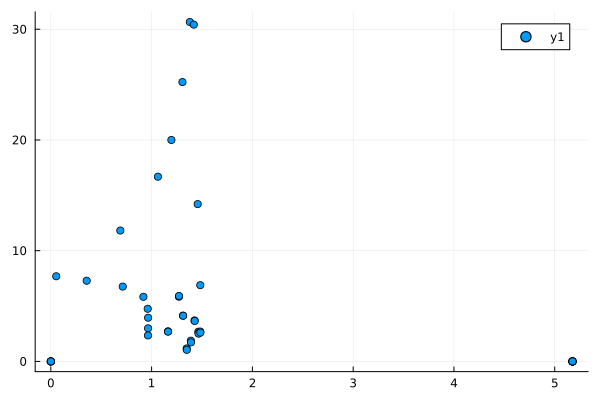

In [ ]:
using Plots
scatter(global_sensitivity_nonbinding, med_dif[361:end])

In [ ]:
med_dif

405-element Vector{Float64}:
   0.0
   3.229836482390965
  10.969570463226773
  23.920657799342735
  55.150368807428094
 110.73246432182168
 172.08639413247693
 278.3746319975453
 381.8277284436772
   0.0
   8.881784197001252e-16
   8.881784197001252e-16
   8.881784197001252e-16
   ⋮
   3.704307686685752
   2.6829029182572413
   2.6986551452209824
   0.0
   2.6880225173558756
   5.913428581779499
   4.1233788116642245
   1.048426372648919
   1.7199683590474706
   3.652232336119141
   2.5076958992494838
   2.604979922362645